In [1]:
import lightkurve as lk

kic_id = 'KIC10011070'
flare_time = 415.62

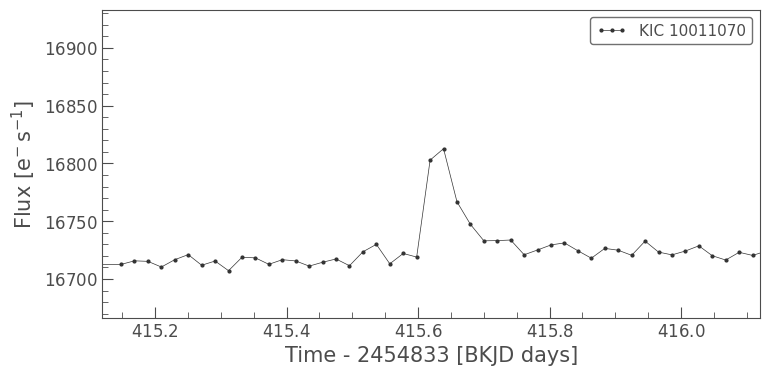

In [2]:
%matplotlib inline
lc = lk.search_lightcurve(kic_id, author="Kepler", cadence="long", quarter=4).download()
lc.plot(marker='o').set_xlim(flare_time-0.5, flare_time+0.5);

In [3]:
tpf = lk.search_targetpixelfile(kic_id, author="Kepler", cadence="long", quarter=4).download()

In [4]:
from src.flare_localization import FlareLocalization
flare = FlareLocalization(flare_time=flare_time, tpf=tpf)

In [5]:
flare.compute_flare_image()


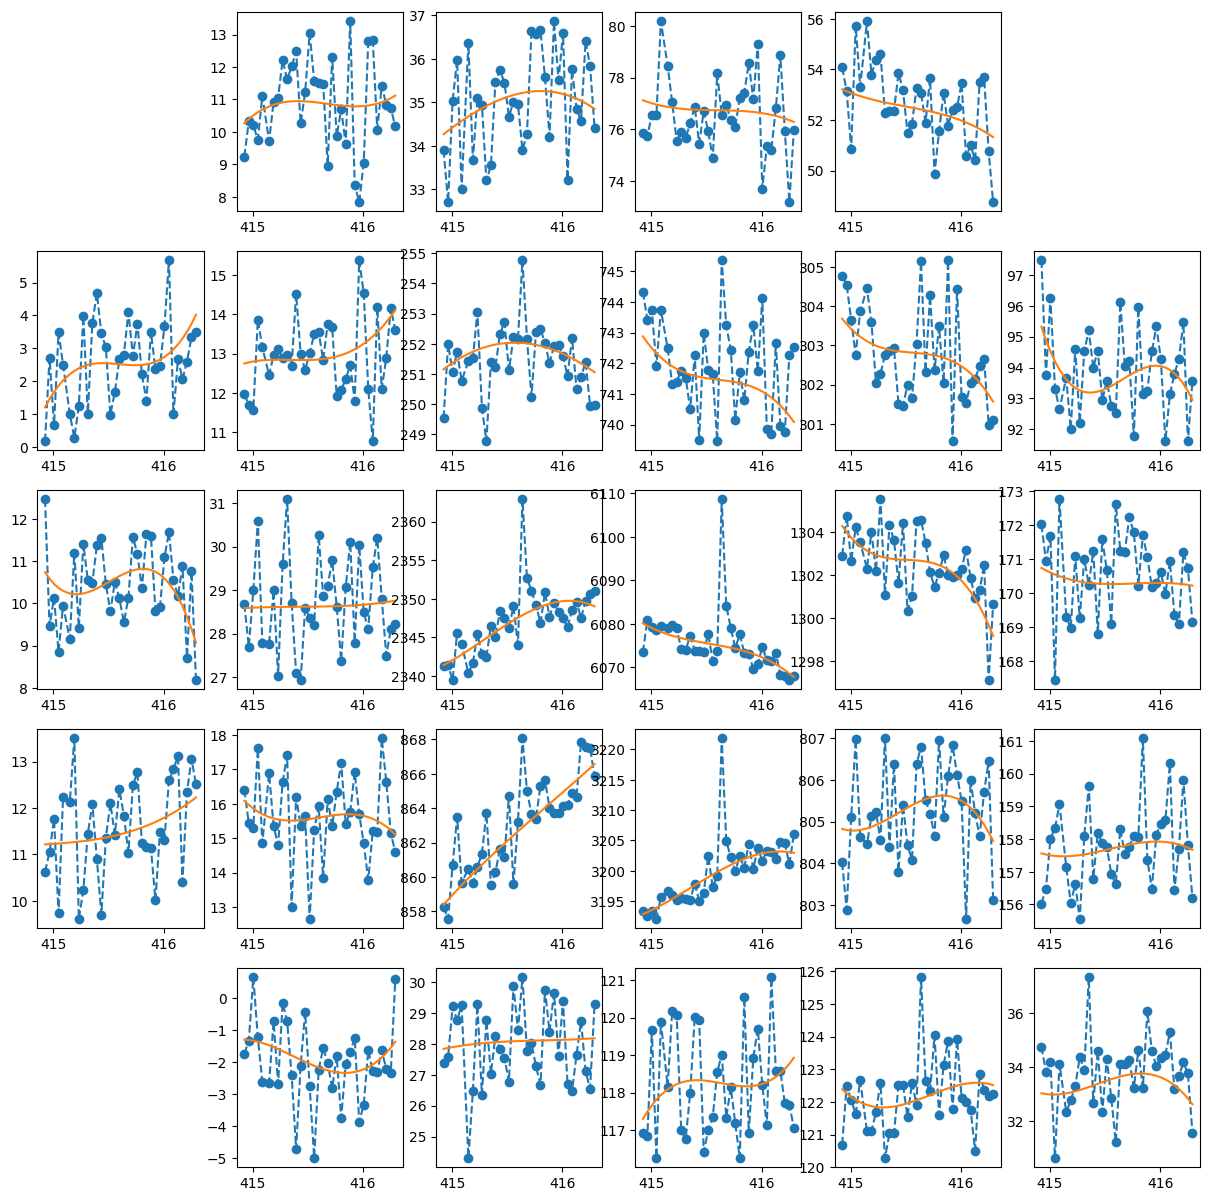

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plotDetrendingPixelFLuxes(time: np.ndarray, flux: np.ndarray, mean_flux: np.ndarray) -> None:
    n_xpix = flux.shape[1]
    n_ypix = flux.shape[2]
    plt.figure(figsize=(15,15))
    c=1
    for i in range(n_xpix):
            i= n_xpix - 1 - i
            for j in range(n_ypix):
                if not(np.isnan(flux[0, i, j])):
                    plt.subplot(n_xpix, n_ypix, c)
                    plt.plot(time, flux[:, i, j], "o--")
                    plt.plot(time, mean_flux[:, i, j], "-")
                c = c + 1
    plt.show()

plotDetrendingPixelFLuxes(time=flare.flare_image.time_within_window_with_flare,
                          flux=flare.flare_image.tpfs_within_window_with_flare,
                          mean_flux=flare.flare_image.quiet_stellar_fluxes_within_window_with_flare)